# Import Assignments From a SQLite Database
In this example, assignments stored in a SQLite database, representing sidewalks that need to be repaired, will be imported into a Workforce Project as assignments.

### Import ArcGIS API for Python
Import the `arcgis` library and some modules within it.
Import sqlite3 and pandas modules

In [1]:
import sqlite3
from datetime import datetime
import pandas as pd
from arcgis.gis import GIS
from arcgis.apps import workforce
from arcgis.geocoding import geocode

### Connect to Organization and Get the Project
Let's connect to ArcGIS Online and find the project.

In [2]:
gis = GIS("https://arcgis.com", "workforce_scripts")
item = gis.content.get("29f2f056e5e04ba383e59737b3f8b340")
project = workforce.Project(item)

Enter password: ········


### View All Assignments in SQLite
Let's connect to the "sidewalk_repairs" database and query all work orders from the "work_orders" table.

In [3]:
connection = sqlite3.connect("sidewalk_repairs.sqlite")
df = pd.read_sql_query("select * from work_orders", connection)
df

,index,id,due_date,address,priority,type,status,description,notes
0,0,1,2019-07-12 00:00:00,"Colombia St & Broadway, San Diego, CA",1,Sidewalk Repair,Completed,The sidewalk needs to be fixed.,Done
1,1,2,2019-07-13 00:00:00,"1800 Fifth Ave, San Diego, CA",1,Sidewalk Repair,Completed,The sidewalk is uneven due to tree roots.,Finished
2,2,3,2019-07-14 00:00:00,"2115 Imperial Ave, San Diego, CA",2,Sidewalk Repair,Backlog,The sidewalk is very uneven.,None
3,3,4,2019-07-15 00:00:00,"South Evans St & Franklin Ave, San Diego, CA",2,Sidewalk Repair,Backlog,Please fix the sidewalk near the intersection,None
4,4,5,2019-07-16 00:00:00,"Market St & 31st St, San Diego, CA",3,Sidewalk Repair,Backlog,Fix my side walk,None
5,5,6,2019-07-17 00:00:00,"Ivy St & Fern St, San Diego, CA",3,Sidewalk Repair,Backlog,Fix the side walk in front of my shop,None


### Extract Specific Assignments to Add
Notice how some orders have a status of "Completed" and how other orders have a status of "Backlog". Let's only query work orders that are in the backlog.

In [4]:
df = pd.read_sql_query("select * from work_orders where status='Backlog'", connection)
df

,index,id,due_date,address,priority,type,status,description,notes
0,2,3,2019-07-14 00:00:00,"2115 Imperial Ave, San Diego, CA",2,Sidewalk Repair,Backlog,The sidewalk is very uneven.,None
1,3,4,2019-07-15 00:00:00,"South Evans St & Franklin Ave, San Diego, CA",2,Sidewalk Repair,Backlog,Please fix the sidewalk near the intersection,None
2,4,5,2019-07-16 00:00:00,"Market St & 31st St, San Diego, CA",3,Sidewalk Repair,Backlog,Fix my side walk,None
3,5,6,2019-07-17 00:00:00,"Ivy St & Fern St, San Diego, CA",3,Sidewalk Repair,Backlog,Fix the side walk in front of my shop,None


### Create An Assignment For Each Row
For each assignment, first geocode the address to get the x,y location (in WGS 84 Web Mercator) of the assignment. Then supply additional attributes. Finally use the batch_add method to add multiple assignments at once (this is faster than using the add method since validation is performed once for all assignments).

In [5]:
assignments = []
for index, row in df.iterrows():
    geometry = geocode(row["address"], out_sr=3857)[0]["location"]
    assignments.append(
        workforce.Assignment(
            project,
            geometry=geometry,
            location=row["address"],
            description=row["description"],
            priority=int(row["priority"]),
            work_order_id=row["id"],
            assignment_type="Sidewalk Repair",
            status="unassigned",
            due_date=pd.to_datetime(row["due_date"])
        )
    )
project.assignments.batch_add(assignments)

[<Assignment 42>, <Assignment 43>, <Assignment 44>, <Assignment 45>]

### Verify the assignments on the map
Let's verify that these sidewalk assignments were added.


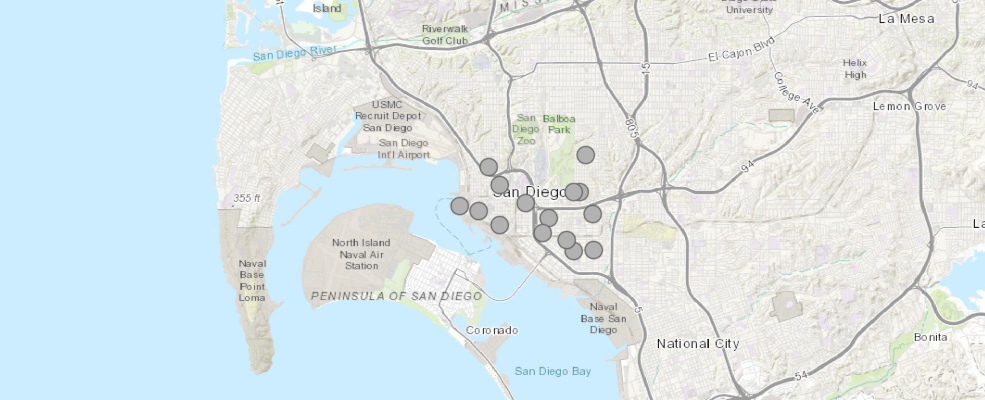

In [6]:
webmap = gis.map("San Diego, CA", zoomlevel=12)
webmap.add_layer(project.assignments_layer)
webmap